**~~Part 2: Profiling & Cleaning~~**
1. ~~Address missing values, outliers, and data type inconsistencies.~~ 
2. ~~Create derived metrics as needed.~~
3. Conduct initial data profiling.

<sup>This part is just initially checking to make sure that the data makes sense (such as 100% being unemployed is probably bad) ~~and setting up for any analysis that will be done later~~.</sup>

**Part 3: Analysis & Modeling**
1. Calculate and visualize correlation coefficients for my first research question. 
2. Develop a basic linear regression or classification model for prediction for my second research question.
3. Create any other plots to show the data as needed.

<sup>Since the data is ready at this point, I should be able to actually start looking at it and find meaning in it.</sup>

Above are copied sections of my [ProjectPlan.md](ProjectPlanItems/ProjectPlan.md) file. The crossed out items have already been done in other parts of this project.

### Initial Data Profiling

To start out, I will finish part 2 above and do a quick look at the final combined dataset I created in [DataA&I+P&C.ipynb](InterimStatusReportItems/DataA&I+P&C.ipynb) to make sure that at a high level nothing looks wrong (like 100% unemployment or 0% graduated highschool or higher).

In [208]:
import pandas as pd

# original dataFrame
df_og = pd.read_csv('merged_education_unemployment_data.csv')

# dataFrame to work with
df = df_og.copy()
coulmns_to_view = ['HS_Grad_or_Higher_Pct',
                   'Avg Annual Total Civilian Non-Institutional Population in State/Area',
                   'Avg Annual Total Unemployment in State/Area',
                   'Annual Percent (%) of Unemployed in State/Area']
df[coulmns_to_view].describe().round(2) # rounding because it added lots of scientific notation

,HS_Grad_or_Higher_Pct,Avg Annual Total Civilian Non-Institutional Population in State/Area,Avg Annual Total Unemployment in State/Area,Annual Percent (%) of Unemployed in State/Area
count,867.00,867.00,867.00,867.00
mean,88.19,4811768.66,181141.82,5.52
std,3.52,5390952.05,244803.27,2.15
min,77.93,389945.00,7420.00,2.06
25%,85.74,1319317.00,39104.00,3.91
50%,88.80,3366596.00,105373.00,5.04
75%,90.88,5636780.00,219819.00,6.78
max,94.98,31093752.00,2287097.00,13.72


`HS_Grad_or_Higher_Pct` was already validated in [DataA&I+P&C.ipynb](InterimStatusReportItems/DataA&I+P&C.ipynb), so looking more at some of the columns about unemployemnt we can see that there is a mean of 5.52% for `Annual Percent (%) of Unemployed in State/Area`. This value does make sense as just from a search we can see that the "Unemployment Rate in the United States averaged 5.67 percent from 1948 until 2025, reaching an all time high of 14.90 percent in April of 2020 and a record low of 2.50 percent in May of 1953." This is from [TradingEconomics](https://tradingeconomics.com/united-states/unemployment-rate) (Stats page) which used data from the U.S. Bureau of Labor Statistics which is the same place the unemployment data originated from. My percentages are were calculated from this equation:
```py
df_unemploy_yearly['Annual Percent (%) of Unemployed in State/Area'] = round((
    df_unemploy_yearly[avg_unemploy] /
    df_unemploy_yearly[avg_labor_force]
) * 100, 2)
```
This uses two other columns made from grouping the months and taking the average since the orginal data was seperated by months and I wanted years. This tells me that the data is fairly accurate as it is pretty close to the mean, max, and min that is shown above in the smaller timeframe of 2005-2022 (excluding 2020). 

### Data Setup

Since most of the data is in counts, I would actually prefer that it be in percentages so this code below creates the columns needed:

In [209]:
edu_counts = [
    'Edu_12th_No_Diploma', 'Edu_HS_GED_or_Equiv',
    'Edu_Some_College_Less_1_Year', 'Edu_Some_College_1_Plus_Year',
    'Edu_Associates_Degree', 'Edu_Bachelors_Degree',
    'Edu_Masters_Degree', 'Edu_Professional_Degree', 'Edu_Doctorate_Degree'
]

for col in edu_counts:
    df[col + '_Pct'] = round((df[col] / df['Total_Pop_25_Plus']) * 100, 2)

cols_to_drop = edu_counts + [
    # all of the populations are similar and so can be removed
    'Total_Pop_25_Plus', 
    'Avg Annual Total Civilian Non-Institutional Population in State/Area',
    'Avg Annual Total Civilian Labor Force in State/Area',
    # since I am wanting to predict unemployment, I will remove related ones
    'Avg Annual Total Employment in State/Area',
    'Avg Annual Total Unemployment in State/Area',
    'Annual Percent (%) of Total Employment in State/Area',
    'Annual Percent (%) of Labor Force Population',
    # this should work regardless of state/year so can be removed
    'State', 'State_FIPS'
]
df = df.drop(columns = cols_to_drop)

Although `HS_Grad_or_Higher_Pct` is great, it ultimately makes all others in the education redundant since it is an aggregate of all the rest so I will be removing it from the model to let other levels shine. Also remove the `HS_Grad_or_Higher_Count` which is similar.

There are also two variables: `Edu_HS_GED_or_Equiv_Pct` and `Edu_12th_No_Diploma_Pct` which are similar so I will drop one of these.

In [210]:
remove_sim = ['HS_Grad_or_Higher_Pct',
              'HS_Grad_or_Higher_Count',
              'Edu_HS_GED_or_Equiv_Pct']
df = df.drop(remove_sim, axis = 1)

This leaves us with these columns:

In [211]:
df.columns

Index(['Year', 'Annual Percent (%) of Unemployed in State/Area',
       'Edu_12th_No_Diploma_Pct', 'Edu_Some_College_Less_1_Year_Pct',
       'Edu_Some_College_1_Plus_Year_Pct', 'Edu_Associates_Degree_Pct',
       'Edu_Bachelors_Degree_Pct', 'Edu_Masters_Degree_Pct',
       'Edu_Professional_Degree_Pct', 'Edu_Doctorate_Degree_Pct'],
      dtype='object')

### Analysis & Modeling

From the [ProjectPlan.md](ProjectPlanItems/ProjectPlan.md) here are the copied reserach questions that I wanted to answer:
1. What is the year to year correlation between the percentage of the population with a Bachelor’s degree or higher and the overall unemployment rate in U.S. states?
2. Can educational attainment variables, when combined with other demographic factors, be used to predict a state’s unemployment rate?

I have modifed it slightly to instead of "Bachelor’s degree or higher" to be "different levels of education," but other than that the questions remain the same.

Since this is not a statistics class*, I will just be making a simple linear regression model. I will also make a random forest regressor model. 

<sup><sup>*concepts/code reused from my STAT207 and IS327 classes, but modified to work with my data</sup></sup>

I will be using these libraries:

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

This is set up needed for the model:

In [213]:
# shuffle data (random state for reproducibility)
df = df.sample(frac = 1, replace = False, random_state = 11272004)

predict = 'Annual Percent (%) of Unemployed in State/Area'
# since I am wanting to predict unemployment, I need to remove them from the model 
X_reg = df.drop([predict], axis = 1)
# then keep the thing we are predicting seperate
y_reg = df[predict]

# then based on this create a split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg,
                                                                    test_size = 0.2,
                                                                    random_state = 11272004)

# since the data has lots of differnt variables scaling is needed
reg_scaler = StandardScaler()
X_reg_train_scaled = reg_scaler.fit_transform(X_reg_train)
X_reg_test_scaled = reg_scaler.transform(X_reg_test)

Now that the set up is done the model can be made:

In [214]:
lr = LinearRegression()
lr.fit(X_reg_train_scaled, y_reg_train)
y_reg_pred_lr = lr.predict(X_reg_test_scaled)

# basic n_estimators and max_depth values chosen 
rf_reg = RandomForestRegressor(n_estimators = 200, max_depth = 15, random_state = 11272004)
rf_reg.fit(X_reg_train_scaled, y_reg_train)
y_reg_pred_rf = rf_reg.predict(X_reg_test_scaled)

We can see how well the model has done:

In [226]:
print("Linear Regression Results:")
print(f"\tRMSE: {mean_squared_error(y_reg_test, y_reg_pred_lr, squared = False):.3f}")
print(f"\tR²: {r2_score(y_reg_test, y_reg_pred_lr):.3f}")

print("\nRandom Forest Regressor Results:")
print(f"\tRMSE: {mean_squared_error(y_reg_test, y_reg_pred_rf, squared = False):.3f}")
print(f"\tRandom Forest R²: {r2_score(y_reg_test, y_reg_pred_rf):.3f}")

Linear Regression Results:
	RMSE: 1.750
	R²: 0.258

Random Forest Regressor Results:
	RMSE: 0.853
	Random Forest R²: 0.824


Above you can see the standard linear regression model did ok, but not the best. We can still get some useful infromation for it:

In [ ]:
lr_reg_coefs = pd.DataFrame(
    lr.coef_,
    columns = ['Linear Regression Coefficient'],
    index = X_reg_train.columns
)

lr_reg_coefs['Abs Coefficient'] = lr_reg_coefs['Linear Regression Coefficient'].abs()

lr_reg_coefs = lr_reg_coefs.sort_values(by = 'Abs Coefficient', ascending = False)
lr_reg_coefs

,Linear Regression Coefficient,Abs Coefficient
Edu_Masters_Degree_Pct,1.283180,1.283180
Edu_Some_College_1_Plus_Year_Pct,0.980050,0.980050
Edu_Bachelors_Degree_Pct,-0.837570,0.837570
Edu_Doctorate_Degree_Pct,-0.524582,0.524582
Edu_Some_College_Less_1_Year_Pct,-0.518270,0.518270
Year,-0.487711,0.487711
Edu_Associates_Degree_Pct,-0.361475,0.361475
Edu_12th_No_Diploma_Pct,0.054271,0.054271
Edu_Professional_Degree_Pct,0.004461,0.004461


The sorted Linear Regression coefficients, despite the model's low predictive power ($R^2 \approx 0.258$), reveal some surprising relationships. The feature with the highest absolute influence is `Edu_Masters_Degree_Pct` ($1.283$), indicating that increases in this percentage are strongly associated with a rise in unemployment, which runs counter to the general economic hypothesis. While, `Edu_Bachelors_Degree_Pct` ($-0.837$) shows the expected strong negative association, suggesting more bachelor degrees reduce unemployment. This could mean that a masters degree is not worth it, but with the low R² this possible contradiction is why I also made the Random Forest model.

On the other hand the random forest results ended up doing better. With the random forest one benefits is that it is easier to see which feature were the most important.

In [229]:
rf_reg_feature_importances = pd.DataFrame(
    rf_reg.feature_importances_,
    columns = ['Random Forest Importance'],
    index = X_reg_train.columns
)
rf_reg_feature_importances = rf_reg_feature_importances.sort_values(by = 'Random Forest Importance', ascending = False)
rf_reg_feature_importances

,Random Forest Importance
Year,0.595689
Edu_Associates_Degree_Pct,0.135759
Edu_12th_No_Diploma_Pct,0.101315
Edu_Bachelors_Degree_Pct,0.041551
Edu_Some_College_1_Plus_Year_Pct,0.036119
Edu_Masters_Degree_Pct,0.027448
Edu_Some_College_Less_1_Year_Pct,0.021137
Edu_Professional_Degree_Pct,0.020761
Edu_Doctorate_Degree_Pct,0.020221


These models clearly show that macroeconomic timing (captured by the `Year` variable) is the overwhelming driver of state unemployment rates, not education. Unemployment is cyclical. It spikes during specific years of economic crises or recessions (like 2008, 2020) regardless of how many PhDs live in a state.

The non-linear Random Forest model performed far better ($R^2 \approx 0.82$) because it understood the "boom and bust" cycles of the economy. Education levels, such as the `Edu_Associates_Degree_Pct` ($0.136$), had minimal importance compared to `Year` ($0.596$), indicating that national recessions and recoveries impact employment much more heavily than the specific mix of educational attainment within a state.

Just to see the actual vs. predicted values for the random forest we can plot this graph.

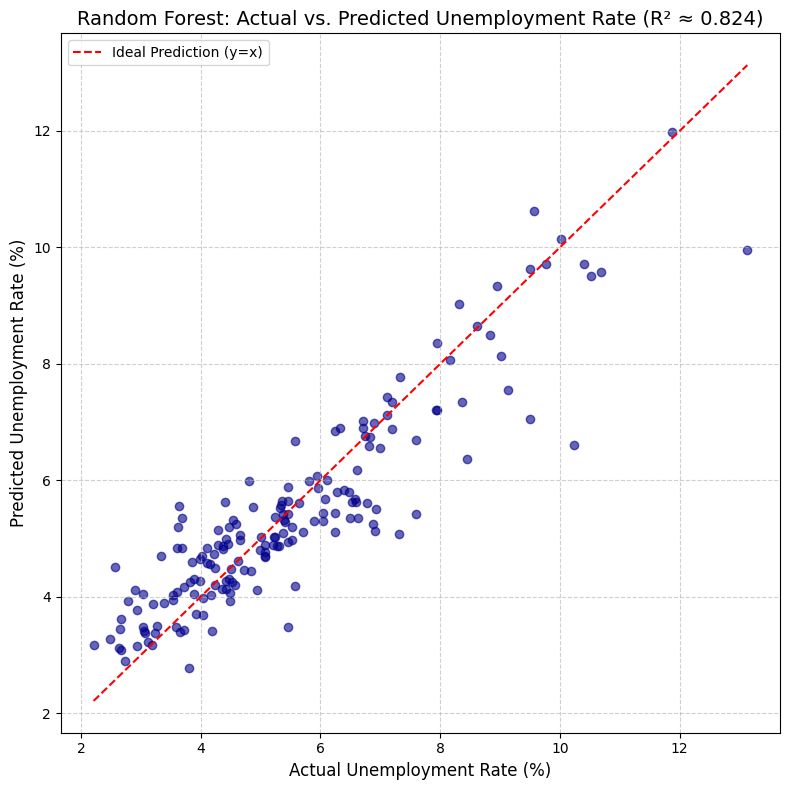

In [217]:
plt.figure(figsize = (8, 8))

# scatter plot of actual vs. predicted values
plt.scatter(y_reg_test, y_reg_pred_rf, alpha = 0.6, color = 'darkblue')

# plot the ideal regression line (y=x)
min_val = min(y_reg_test.min(), y_reg_pred_rf.min())
max_val = max(y_reg_test.max(), y_reg_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction (y=x)')

plt.title(f'Random Forest: Actual vs. Predicted Unemployment Rate (R² ≈ {r2_score(y_reg_test, y_reg_pred_rf):.3f})', fontsize = 14)
plt.xlabel('Actual Unemployment Rate (%)', fontsize = 12)
plt.ylabel('Predicted Unemployment Rate (%)', fontsize = 12)
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.legend()
plt.tight_layout()

# save for later use
plt.savefig('ForestRegressorGraph-AvsP.png')

From the original I wanted to also see the relationship between `HS_Grad_or_Higher_Pct` and `Annual Percent (%) of Unemployed in State/Area` as that might have something as well.

This can be seen by this:

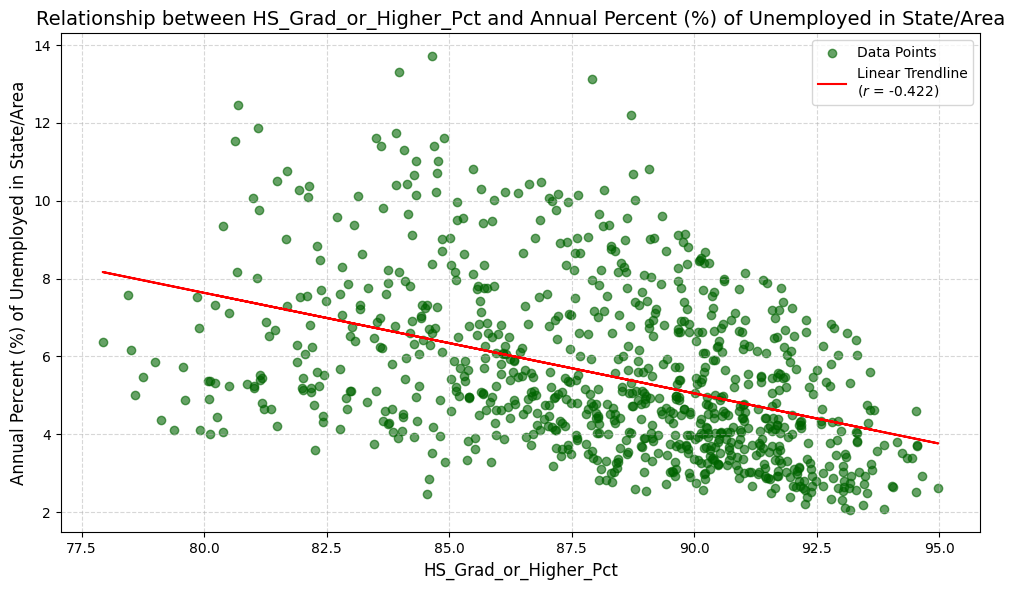

In [218]:
# get the correlation 
x = 'HS_Grad_or_Higher_Pct'
y = 'Annual Percent (%) of Unemployed in State/Area'

correlation = df_og[x].corr(df_og[y])

plt.figure(figsize=(10, 6))

# scatter plot of the data
plt.scatter(df_og[x], df_og[y], alpha = 0.6, color = 'darkgreen', label = 'Data Points')

# calculate the trendline
# np.polyfit(X, Y, 1) fits a 1st degree polynomial (a straight line)
z = np.polyfit(df_og[x], df_og[y], 1)
p = np.poly1d(z)

# plot the trendline
plt.plot(df_og[x], p(df_og[x]), "r-", 
         label=f'Linear Trendline\n($r$ = {correlation:.3f})')

# labels and title
plt.title(f'Relationship between {x} and {y}', fontsize = 14)
plt.xlabel(x, fontsize = 12)
plt.ylabel(y, fontsize = 12)
plt.grid(True, linestyle = '--', alpha=0.5)
plt.legend()
plt.tight_layout()

# save for later use
plt.savefig('hs_grad_vs_unemployment_rate_final.png')

This graph above shows a moderately negative linear relationship between the percentage of the population with a high school degree or higher (`HS_Grad_or_Higher_Pct`) and the state's unemployment rate. The correlation coefficient of $r = -0.422$ means that as the high school graduation rate increases (moving right on the x-axis), the annual unemployment rate tends to decrease (moving down on the y-axis).

This can support the general economic hypothesis that higher educational attainment is associated with better employment outcomes. However, since the correlation is just not close to $-1.0$, the relationship is not too strong enough on its own which can indicate that other factors, like the specific `Year`, can responsible for much of the remaining variation in unemployment rates. Which is what we saw before.

### Done

As a summary of this document:
- Initial Data Profiling (Checking Data)
- Data Setup (getting columns needed and final checks)
- Modeling (Linear Regressions + Plots)
- Analysis (Explaining findings)
- Load (Saving the plot images)

The resulting [ForestRegressorGraph-AvsP](ForestRegressorGraph-AvsP.png) and [hs_grad_vs_unemployment_rate_final.png](hs_grad_vs_unemployment_rate_final.png) being made.

<sup>This file is not a full report. Just to make the models and simple analysis. **This file is done.**</sup>